In [1]:
from turtle import color
from sympy import true
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import matplotlib.pyplot as plt
import numpy as np
import random
from data import seqDataLoader
from data import Vocab,read_dataset,tokenize
from models import RnnModelScratch
from models import GRUModelScratch
from models import lstmModelScratch
from tqdm import tqdm
import re

In [2]:
def create_vocabulary(file):
    # 加载数据集 和 词表
    lines = read_dataset(file)
    tokens = tokenize(lines)
    corpus = [tk for token in tokens for tk in token]
    voc = Vocab(corpus)
    return voc,corpus

def train(net,corpus,epoches,device='cpu',lr=1.2):

  dataLoader = seqDataLoader(corpus,batch_size=16,num_steps=5,is_random=False)

  loss = nn.CrossEntropyLoss()
  if isinstance(net,nn.Module):
    opt = torch.optim.SGD(net.parameters(),lr=lr)
  else:
    opt = torch.optim.SGD(net.params,lr=lr)

  consine_scheduler = CosineAnnealingLR( opt,T_max=120,eta_min=1e-3 )
  scheduler = GradualWarmupScheduler(opt,2,30,consine_scheduler)

  state = None

  total_losses = []
  with tqdm(total = epoches,desc='模型训练中') as pbar:
    for epoch in range(epoches):
      losses = train_epoch(net,state,dataLoader,loss,opt,device=device,is_random=True)
      total_losses.append(losses)
      if (epoch+1) % 1 == 0:
        pbar.update(1)
      scheduler.step()
        
  return total_losses



def train_epoch(model,state,train_iter,loss,opt,is_random=False,device='cpu'):
  losses = 0
  total = 0
  for X,Y in train_iter:   # 有个 batches 数量的 序列，并且序列式拥有顺序的
    if state is None or is_random:
      state = model.begin_state(X.shape[0],device)
    else:
      if isinstance(state,tuple):
        for s in state:
          s.detach_()
      else:
        state.detach_()     # 对每个batch执行时间步截断
  
    X = X.to(device)
    y_pre,state = model(X,state)
    # y = F.one_hot(Y.T.reshape(-1),num_classes=y_pre.shape[-1]).float().to(device)
    y = Y.T.reshape(-1).to(device)
    l = loss(y_pre,y).mean()
    opt.zero_grad()
    l.backward()
    clip_grad(model,1)   # 计算梯度并梯度裁切
    opt.step()
    losses += l.item() * X.size(0)
    total += X.size(0)
  return losses/total


def clip_grad(model,theta):
  if isinstance(model,nn.Module):
    params = [p for p in model.parameters() if p.requires_grad]   # model.parameters()  返回的是参数迭代对象，每个迭代对象是各层网络的参数矩阵
  else:
    params: list = model.params

  tmp = sum(torch.sum(p ** 2) for p in params)
  norm = torch.sqrt(tmp)

  if norm > theta:
    for p in params:
      if p.grad is not None:
        p.grad = p.grad * theta / norm
  
  # torch.nn.utils.clip_grad.clip_grad_norm_(model.parameters(),theta)


In [3]:
device = 'cuda:0'
voc,corpus = create_vocabulary('../dataset/time_machine.txt')
corpus = voc[corpus]

# 自定义神经网络模块

In [10]:
# 加载模型
net_rnn = RnnModelScratch(voc_size=len(voc),num_hiddens=256,device=device,num_layers=3)
total_losses_rnn = train(net_rnn,corpus,300,device,lr=1)

模型训练中: 100%|██████████████████████████████████████████████████████████| 300/300 [16:06<00:00,  3.22s/it]


In [11]:
net_gru = GRUModelScratch(voc_size=len(voc),num_hiddens=256,device=device)
total_losses_gru = train(net_gru,corpus,100,device,lr=1)

模型训练中: 100%|██████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.04s/it]


In [12]:
net_lstm = lstmModelScratch(voc_size=len(voc),num_hiddens=256,device=device)
total_losses_lstm = train(net_lstm,corpus,300,device,lr=1)

模型训练中: 100%|██████████████████████████████████████████████████████████| 300/300 [17:41<00:00,  3.54s/it]


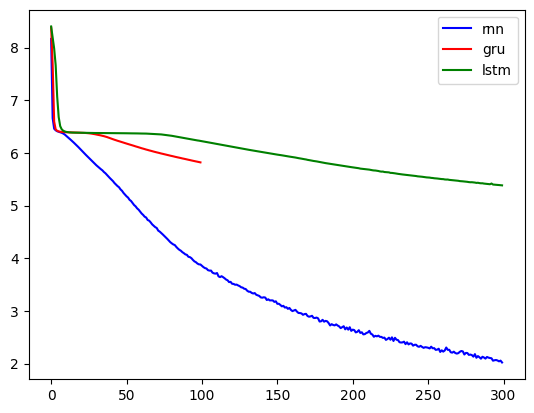

In [13]:
plt.plot(range(len(total_losses_rnn)),total_losses_rnn,color='blue',label='rnn')
plt.plot(range(len(total_losses_gru)),total_losses_gru,color='red',label='gru')
plt.plot(range(len(total_losses_lstm)),total_losses_lstm,color='green',label='lstm')
plt.legend()
plt.show()

In [4]:
def predict(corpus,prex_nums,model,time_step,device):
    outputs = [ corpus[0],corpus[1],corpus[2] ]
    def get_data():
        return torch.tensor(outputs[-time_step:]).reshape(1,time_step).to(device)
    state = model.begin_state(1,device)
    for i in corpus[time_step:]:
        _,state = model(get_data(),state)
        outputs.append(i)
    for i in range(prex_nums):
        y,state = model(get_data(),state)
        y = torch.argmax(y,dim=-1)
        outputs += [y_.item() for y_ in y]
    return outputs,state

In [15]:
# rnn_predict
with torch.no_grad():
    str = ' I took the starting lever in one hand'
    str = re.sub('[^A-Za-z0-9]',' ',str).lower().split()
    corpus = voc[str]
    predict_str,state = predict(corpus,10,net_rnn,3,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[4, 148, 1, 1010, 261, 7, 36, 95, 1, 645, 4, 336, 4, 135, 66, 12, 42, 3, 1122, 7, 1, 2, 300, 248, 355, 8, 2, 1, 371, 7, 74, 602, 1, 691, 2, 359, 2, 1]
i took the starting lever in one hand the distributing i huge i eyes up had came of preserved in the and men years beautiful was and the possibly in thing short the showed and further and the


In [16]:
# gru_predict
with torch.no_grad():
    str = ' I took the starting lever in one hand'
    str = re.sub('[^A-Za-z0-9]',' ',str).lower().split()
    corpus = voc[str]
    predict_str,state = predict(corpus,10,net_gru,3,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[4, 148, 1, 1010, 261, 7, 36, 95, 1, 2, 2, 19, 8, 1, 6, 1, 19, 1, 19, 75, 46, 75, 8, 6, 6, 1, 1, 1, 19, 46, 75, 75, 8, 6, 6, 1, 1, 1]
i took the starting lever in one hand the and and time was the to the time the time traveller machine traveller was to to the the the time machine traveller traveller was to to the the the


In [17]:
# lstm_predict
with torch.no_grad():
    str = ' I took the starting lever in one hand'
    str = re.sub('[^A-Za-z0-9]',' ',str).lower().split()
    corpus = voc[str]
    predict_str,state = predict(corpus,10,net_lstm,3,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[4, 148, 1, 1010, 261, 7, 36, 95, 1, 3, 2, 19, 1, 12, 4, 157, 12, 12, 6, 64, 5, 41, 5, 40, 3, 40, 73, 1, 19, 4, 157, 75, 12, 6, 6, 5, 41, 1]
i took the starting lever in one hand the of and time the had i sun had had to been a be a little of little man the time i sun traveller had to to a be the


# torch.nn 训练模块

In [5]:
# 这里很经典，如果要将rnn和linear结合起来输出就不能直接用 nn.Sequential ,因为nn.Sequential接受不到模型隐藏层的中间结果
# GRU 期望输入 (time_step,batch_size,features) 
# MLP 期望输出 (batch_size,features)
def error_test():
    '''
    
    这个是nn.Moudule调用rnn模块的错误示例  -->  本质原因是 nn.Sequential 拿不到隐藏层中间的向量从而进行适配操作
    
    '''
    gru_layyer = nn.GRU(1,256)
    rnn_layyer = nn.RNN(1,256)
    model_gru = nn.Sequential(
        gru_layyer,
        nn.Linear(256,len(voc)),
        nn.ReLU()
    ).to(device)
    model_rnn = nn.Sequential(
        rnn_layyer,
        nn.Linear(256,len(voc)),
        nn.ReLU()
    ).to(device)

In [6]:
class rnn_torch(nn.Module):
  def __init__(self, voc_size,hidden_size,select_model,num_layers=1,num_directions=1) -> None:
    '''
    select_model:
      1:  rnn
      2:  gru
      3:  lstm
    '''
    super().__init__()
    self.voc_size = voc_size
    self.hidden_size = hidden_size
    self.selece_model = select_model
    self.num_layers = num_layers
    self.num_directions = num_directions
    self.rnn = nn.RNN(voc_size,hidden_size)   # (time_step,batch_size,voc_size)
    self.gru = nn.GRU(voc_size,hidden_size)
    self.lstm = nn.LSTM(voc_size,hidden_size)
    self.dense = nn.Linear(hidden_size,voc_size)
  
  def forward(self,X,state):
    '''
    x -> (batch_size,time_step,voc_size)
    '''
    X = X.long()
    X = F.one_hot(X.T,num_classes=self.voc_size).float()
    if self.selece_model == 1:
      X,state = self.rnn(X,state)
    elif self.selece_model == 2:
      X,state = self.gru(X,state)
    elif self.selece_model == 3:
      X,state = self.lstm(X,state)
    X = X.reshape(-1,self.hidden_size)
    Y = torch.relu(self.dense(X))
    return Y,state
  def begin_state(self,batch_size,device='cpu'):
    if self.selece_model == 1 or self.selece_model == 2:
      return torch.zeros((self.num_directions*self.num_layers,batch_size,self.hidden_size),device=device).float()
    elif self.selece_model == 3:
      return (torch.zeros((self.num_directions*self.num_layers,batch_size,self.hidden_size),device=device).float(),
              torch.zeros((self.num_directions*self.num_layers,batch_size,self.hidden_size),device=device).float())


In [7]:
# rnn
torch_net = rnn_torch(voc_size=len(voc),hidden_size=256,select_model=1).to(device)
total_losses_torch = train(torch_net,corpus,200,device,lr=1)

模型训练中:  16%|█████████▏                                                 | 31/200 [00:38<03:23,  1.20s/it]/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
模型训练中: 100%|██████████████████████████████████████████████████████████| 200/200 [04:00<00:00,  1.20s/it]


In [8]:
# gru
torch_net_gru = rnn_torch(voc_size=len(voc),hidden_size=256,select_model=2).to(device)
total_losses_torch_gru = train(torch_net_gru,corpus,200,device,lr=1)

模型训练中: 100%|██████████████████████████████████████████████████████████| 200/200 [04:48<00:00,  1.44s/it]


In [9]:
# lstm
torch_net_lstm = rnn_torch(voc_size=len(voc),hidden_size=256,select_model=3).to(device)
total_losses_torch_lstm = train(torch_net_lstm,corpus,300,device,lr=1)

模型训练中: 100%|██████████████████████████████████████████████████████████| 300/300 [07:54<00:00,  1.58s/it]


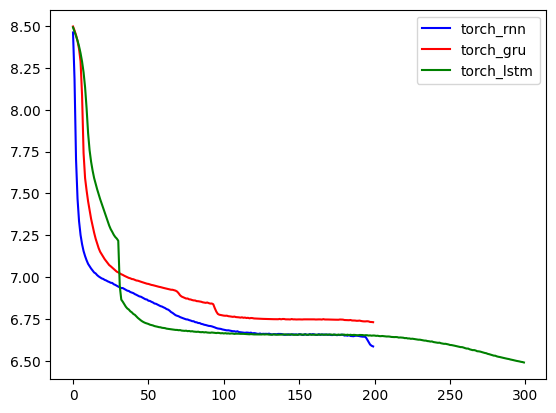

In [10]:
plt.plot(range(len(total_losses_torch)),total_losses_torch,color='blue',label='torch_rnn')
plt.plot(range(len(total_losses_torch_gru)),total_losses_torch_gru,color='red',label='torch_gru')
plt.plot(range(len(total_losses_torch_lstm)),total_losses_torch_lstm,color='green',label='torch_lstm')
plt.legend()
plt.show()

In [11]:
# rnn_predict
with torch.no_grad():
    str = ' I took the starting lever in one hand'
    str = re.sub('[^A-Za-z0-9]',' ',str).lower().split()
    corpus = voc[str]
    predict_str,state = predict(corpus,10,torch_net,3,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[4, 148, 1, 1010, 261, 7, 36, 95, 1, 2, 2, 19, 1, 1, 2, 19, 46, 1, 2, 2, 19, 1, 1, 2, 19, 46, 1, 2, 2, 19, 1, 1, 2, 19, 46, 1, 2, 2]
i took the starting lever in one hand the and and time the the and time machine the and and time the the and time machine the and and time the the and time machine the and and


In [12]:
# gru_predict
with torch.no_grad():
    str = ' I took the starting lever in one hand'
    str = re.sub('[^A-Za-z0-9]',' ',str).lower().split()
    corpus = voc[str]
    predict_str,state = predict(corpus,10,torch_net_gru,3,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[4, 148, 1, 1010, 261, 7, 36, 95, 1, 1, 4, 19, 19, 3, 3, 4, 1, 1, 12, 19, 19, 3, 3, 4, 1, 1, 12, 19, 19, 3, 3, 4, 1, 1, 12, 19, 19, 3]
i took the starting lever in one hand the the i time time of of i the the had time time of of i the the had time time of of i the the had time time of


In [13]:
# lstm_predict
with torch.no_grad():
    str = ' I took the starting lever in one hand'
    str = re.sub('[^A-Za-z0-9]',' ',str).lower().split()
    corpus = voc[str]
    predict_str,state = predict(corpus,10,torch_net_lstm,3,device)
    print(predict_str)
    predict_str = ' '.join(voc(predict_str))
    print(predict_str)

[4, 148, 1, 1010, 261, 7, 36, 95, 1, 2, 2, 40, 3, 1, 2, 1, 40, 3, 3, 3, 1, 1, 1, 40, 3, 3, 3, 1, 1, 1, 40, 3, 3, 3, 1, 1, 1, 40]
i took the starting lever in one hand the and and little of the and the little of of of the the the little of of of the the the little of of of the the the little
